In [8]:
!pip install python-dotenv
!pip3 install psycopg2-binary

In [10]:
import os
import random
import pandas as pd
import numpy as np
import keras
from keras import layers
from tensorflow.keras.preprocessing import image
from dotenv import load_dotenv
from PIL import Image
import matplotlib.pyplot as plt
import psycopg2
from psycopg2 import pool
import pandas as pd
import csv
from io import StringIO
import math
from azurecv import display_image_grid
from azurecv import (image_embedding, text_embedding, get_cosine_similarity, 
                     get_image_embedding_multiprocessing, 
                     search_by_image, search_by_text)

### Get embeddings for all images

In [22]:
# GET EMBEDDINGS
# Load image array data from .npz file
img_arr = "mnistlikedataset128x1.npz"
with np.load(img_arr) as data:
    images = data['DataX'] # col name

# Load trained autoencoder model
autoencoder_path = 'autoencoder_model.keras'
autoencoder = keras.models.load_model(autoencoder_path)
encoder = autoencoder.layers[1]  # Get encoder part

# Get embeddings for all images
embeddings = encoder.predict(images)

# Flatten the embeddings
flattened_embeddings = embeddings.reshape(embeddings.shape[0], -1)
print(flattened_embeddings.shape)

# Normalize the embeddings
normalized_embeddings = flattened_embeddings / np.linalg.norm(flattened_embeddings, axis=1)[:, np.newaxis]

36/36 [==============================] - 4s 2ms/step
(1150, 524288)


#### Dimensionality Reduction using PCA

In [23]:
from sklearn.decomposition import PCA

# Initialize PCA with the desired number of components
pca = PCA(n_components=1150)

# Fit PCA to data
pca.fit(normalized_embeddings)

# Transform data to the lower-dimensional space
embeddings_reduced = pca.transform(normalized_embeddings)

# 'embeddings_reduced' now contains the embeddings in the reduced space
# with shape (n_samples, n_components)


In [24]:
roicsv = pd.read_csv('roi_id.csv')
roi_ids = roicsv['roi_id']

In [25]:
# print(embeddings_reduced.tolist())
print(type(embeddings_reduced.tolist()))
print(type(roi_ids.tolist()))

<class 'list'>
<class 'list'>


In [26]:
df_roi = pd.DataFrame(roi_ids.tolist(), columns=['ROI_ID'])
df_embeddings = pd.DataFrame([str(emb) for emb in embeddings_reduced.tolist()], columns=['embedding'])
df = pd.concat([df_roi, df_embeddings], axis=1)
df.head(5)

,ROI_ID,embedding
0,001_1035_1,"[-0.06963907927274704, 0.43884173035621643, 0...."
1,001_115_2,"[-0.05103757232427597, 0.016412675380706787, -..."
2,001_115_3,"[-0.1065797209739685, -0.10693076252937317, -0..."
3,001_115_4,"[-0.08835367113351822, 0.22169826924800873, -0..."
4,001_1150_5,"[0.06702021509408951, 0.018582487478852272, 0...."


### Connect with Azuire CosmoDB

In [27]:
# Load environment variables
load_dotenv()
host = os.getenv("POSTGRES_HOST")
dbname = os.getenv("POSTGRES_DB_NAME")
user = os.getenv("POSTGRES_USER")
password = os.getenv("POSTGRES_PASSWORD")
sslmode = "require"
table_name = "img_embedding"

# Build a connection string from the variables
conn_string = "host={0} user={1} dbname={2} password={3} sslmode={4}".format(host, user, dbname, password, sslmode)

postgreSQL_pool = psycopg2.pool.SimpleConnectionPool(1, 20, conn_string)
if (postgreSQL_pool):
    print("Connection pool created successfully")

# Get a connection from the connection pool
conn = postgreSQL_pool.getconn()
cursor = conn.cursor()

Connection pool created successfully


In [28]:
sio = StringIO()
writer = csv.writer(sio)
writer.writerows(df.values)
sio.seek(0)

cursor.execute("CREATE TEMPORARY TABLE vector_tbl (roi_id TEXT PRIMARY KEY, embedding VECTOR(1150)) ON COMMIT DROP;")

cursor.copy_expert("COPY vector_tbl FROM STDIN CSV", sio)

cursor.execute(f"""INSERT INTO {table_name} (roi_id, embedding)
                SELECT * FROM vector_tbl
                ON conflict (roi_id) DO NOTHING;""")

conn.commit()

### QUERY CLOSEST 10 IMAGES

In [29]:
# To view the first 10 rows inserted into the table
# Fetch all rows from table
cursor.execute(f"SELECT * FROM {table_name} limit 10;")
rows = cursor.fetchall()

# Print all rows
for row in rows:
    print(f"Data row = ({row[0]}, {row[1]})")

Data row = (001_1035_1, [-0.06963908,0.43884173,0.032449905,-0.096922986,0.2669103,0.05744942,-0.06274486,-0.061696425,-0.021113636,-0.032457538,-0.043192666,-0.054448333,-0.007280936,-0.0155705055,-0.036754232,0.035637993,-0.0564473,-0.04538919,0.029103493,0.005078749,0.0003213017,0.0040724683,-0.028776046,0.0058395397,0.026771719,-0.012552395,0.02392,0.017210623,-0.026684428,0.025282886,0.021441197,0.033339158,0.00852074,0.012309744,0.0009607308,0.011765652,0.0021580998,0.005051708,-0.009031216,0.0059966748,0.00663132,-0.029349165,0.024947353,-0.03234386,0.002345329,0.02288556,0.007027924,0.010502847,-0.039198603,0.033699766,0.02402434,-0.0043700133,0.011418152,0.016660746,-0.0040794485,0.010542429,-0.027858537,0.006354919,0.008742261,-0.00042945432,-0.007349221,0.007600403,-0.034361616,-0.0053586815,0.033281874,-0.030482294,0.0067899525,-0.009722932,-0.009970432,0.0052588223,0.0030337684,-0.015325574,-0.0009715021,-0.0036254658,-0.015641509,-0.0005588876,0.0009831927,-0.0072056623,0


Index is also the row of the img in the dataset

417

Compare with last 3 digits of the first image
-------------------------------------
('002_2530_418', '[-0.026631186,-0.07186835,-0.041644193,-0.027993329,0.05920204,-0.07913309,-0.1072041,-0.030247215,0.031182183,-0.035373516,-0.029697385,-0.009617289,0.029560588,0.0057317084,-0.030265871,0.03931311,0.011588601,-0.0060032103,0.031979624,-0.044424374,0.0053846547,-0.023609454,0.0059772166,-0.0059092483,0.031688035,-0.05302178,0.033565033,-0.01328788,-0.015197514,0.0146145485,-0.012691096,0.006197465,-0.03712106,0.005825052,-0.0064403894,-0.009018652,0.004323692,0.011212565,-0.021770442,0.019367615,0.026648942,0.0069636866,-0.016058017,-0.010116497,0.026710808,-0.00035812389,0.008982239,-0.0065103667,-0.0018316406,-0.007615588,0.0006558603,-0.014519715,0.02476168,-0.0038505595,-0.00648604,0.012591282,0.009992728,0.0014974754,0.010515423,-0.021181345,0.0018189303,-0.012950537,0.008269568,0.011448423,0.0037022897,-0.009151124,-0.002729

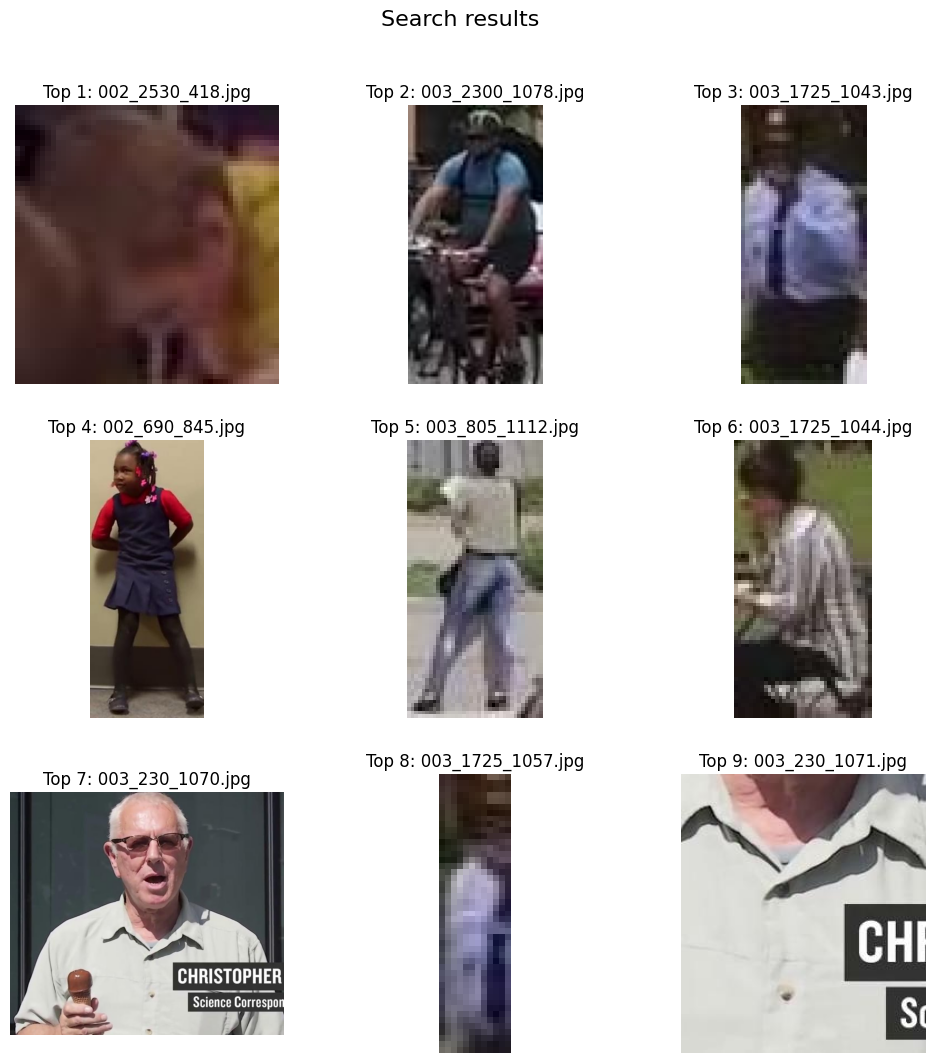

In [60]:
# Generate random index
rand_row = random.randint(0, len(roi_ids)-1)
EMBEDDING_QUERY = embeddings_reduced[rand_row]
print()
print("Index is also the row of the img in the dataset")
print()
print(rand_row)
print()
print("Compare with last 3 digits of the first image")
print("-------------------------------------")

# Vector search
topn = 9
cursor.execute(f"SELECT * FROM {table_name} ORDER BY embedding <=> %s LIMIT {topn}", (str(EMBEDDING_QUERY.tolist()),))

# Display the results
rows = cursor.fetchall()
for row in rows:
    print(row)

root_dir = '.\image-cropped-rois\\'
print(os.path.join(root_dir, '002_1380_252' + '.jpg'))

# Display the similar images
images = [row[0] + ".jpg" for row in rows]
path = [root_dir + row[0] + ".jpg" for row in rows]
captions = [f"Top {i+1}: {os.path.basename(images[i])}" for i in range(len(images))]
ncols = 3
nrows = math.ceil(len(images)/ncols)
display_image_grid(path, captions, 'Search results' , nrows, ncols)